In [1]:
!ls

'=0.2.1'			     environmentSetup.txt
 Miniconda3-latest-Linux-x86_64.sh   healthModel
 _vizdoom			     model
 _vizdoom.ini			     pastVersions
 doomHealthRLv1.ipynb		     policyGradBasic
 doomHealthRLv2.ipynb		     policyGradientv2.ipynb
 doomRL				     tensorboard
 doomRLv2.ipynb			     tests.ipynb
 doomRLv3.ipynb			     vizdoom-crash.log


In [2]:
!which python

/mnt/c/Users/rzamb/Documents/Desktop/UMD/612_deep_learning/doomRL/doomRL/bin/python


In [1]:
from vizdoom import *
import random
#import time

In [2]:
from vizdoom import DoomGame
from vizdoom import Button
from vizdoom import GameVariable
from vizdoom import ScreenFormat
from vizdoom import ScreenResolution

In [3]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

In [4]:
import itertools as it
from collections import deque
from random import sample
from time import sleep, time


import skimage.color
import skimage.transform
import tensorflow as tf
from tensorflow.keras import Model, Sequential
#from tensorflow.keras.layers import BatchNormalization, Conv2D, Dense, Flatten, ReLU
from tensorflow.keras.optimizers import SGD

from tensorflow import keras
from tensorflow.keras import layers


from tqdm import trange

2023-08-08 21:28:48.744858: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-08 21:28:49.066953: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-08 21:28:51.728195: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-08 21:28:51.735173: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-08 21:29:05.866031: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [7]:
game = DoomGame()
#game.set_doom_scenario_path("basic.wad")
wadFilePath = "/mnt/c/Users/rzamb/Documents/Desktop/UMD/612_deep_learning/doomRL/doomRL/lib/python3.10/site-packages/vizdoom/scenarios/health_gathering_supreme.wad"
game.set_doom_scenario_path(wadFilePath)
#game.set_doom_map("map01")

In [8]:
# Rendering Options
game.set_screen_resolution(ScreenResolution.RES_640X480)
game.set_screen_format(ScreenFormat.RGB24)
game.set_render_hud(True) # If true it shows you the game dock with: ammo, health, arms, face, armor
game.set_render_crosshair(False) # If true it shows the cross indicating where the weapon is aiming
game.set_render_weapon(True)
game.set_render_decals(False) # No visible changes noted when set to true 
game.set_render_particles(False) # No visible changes noted when set to true 

In [9]:
# Setting buttins that can be used by the agent
game.add_available_button(Button.TURN_LEFT)
game.add_available_button(Button.TURN_RIGHT)
game.add_available_button(Button.MOVE_FORWARD)

In [10]:
# Determine which game variables (health, ammo, weapon availability etc.) will be included in the state we get in each timestep
game.add_available_game_variable(GameVariable.HEALTH)

In [11]:
# Other settings such as the visibility of the window, the episode timeout (in tics/frames), or start time
game.set_episode_timeout(2100)
game.set_episode_start_time(10)
game.set_window_visible(True)

In [15]:
game.set_living_reward(1)
game.set_death_penalty(-100)

In [16]:
game.init() # A pop up window should appear

## Game Runtime - Random Actions
A single Doom "game" is called an episode. Episodes are independent and finish on player's death, timeout, or when some custom conditions are satisfied (e.g., the agent acomplishes some task), defined by scenario. In this example, the episode finishes after 300 tics or when the monster gets killed. Each action produces a reward: -6 for shooting and missing, 100 for killing the monster, and -1 otherwise (it would be -5, 100 and 0 accordingly but the living reward is set to -1).

In [17]:
#game = DoomGame()
#game.load_config("basic.cfg")
#game.init()

shoot = [0, 0, 1]
left = [1, 0, 0]
right = [0, 1, 0]
actions = [shoot, left, right]

episodes = 10
totalRewards = []
for i in range(episodes):
    print("Episode #" + str(i + 1))
    game.new_episode() # Starts a new episode. It is not needed right after init() but it doesn't cost much. At least the loop is nicer.
    while not game.is_episode_finished():
        state = game.get_state() # Gets the state

        # Which consists of:
        n           = state.number
        vars        = state.game_variables
        screen_buf  = state.screen_buffer
        depth_buf   = state.depth_buffer
        labels_buf  = state.labels_buffer
        automap_buf = state.automap_buffer
        labels      = state.labels

        # Makes a random action and get remember reward.
        reward = game.make_action(random.choice(actions))
        
        # Makes a "prolonged" action and skip frames:
        # skiprate = 4
        # reward = game.make_action(choice(actions), skiprate)

        # The same could be achieved with:
        # game.set_action(choice(actions))
        # game.advance_action(skiprate)
        # reward = game.get_last_reward()

        # Prints state's game variables and reward.
        print("State #" + str(n))
        print("Game variables:", vars)
        print("Reward:", reward)
        print("=====================")
        
        sleep_time = 0.02

        if sleep_time > 0:
            sleep(sleep_time) # removed time.

    # Check how the episode went.
    print("Episode finished.")
    print("Total reward:", game.get_total_reward())
    print("************************")
    totalRewards.append(game.get_total_reward())
    sleep(2) # removed time.

Episode #1
State #1
Game variables: [92.]
Reward: 1.0
State #2
Game variables: [92.]
Reward: 1.0
State #3
Game variables: [92.]
Reward: 1.0
State #4
Game variables: [92.]
Reward: 1.0
State #5
Game variables: [92.]
Reward: 1.0
State #6
Game variables: [92.]
Reward: 1.0
State #7
Game variables: [92.]
Reward: 1.0
State #8
Game variables: [92.]
Reward: 1.0
State #9
Game variables: [92.]
Reward: 1.0
State #10
Game variables: [92.]
Reward: 1.0
State #11
Game variables: [92.]
Reward: 1.0
State #12
Game variables: [92.]
Reward: 1.0
State #13
Game variables: [92.]
Reward: 1.0
State #14
Game variables: [92.]
Reward: 1.0
State #15
Game variables: [92.]
Reward: 1.0
State #16
Game variables: [92.]
Reward: 1.0
State #17
Game variables: [92.]
Reward: 1.0
State #18
Game variables: [92.]
Reward: 1.0
State #19
Game variables: [92.]
Reward: 1.0
State #20
Game variables: [92.]
Reward: 1.0
State #21
Game variables: [92.]
Reward: 1.0
State #22
Game variables: [92.]
Reward: 1.0
State #23
Game variables: [92.

In [18]:
# Observing total rewards in each episode
totalRewards

[475.0, 603.0, 475.0, 475.0, 539.0, 475.0, 475.0, 475.0, 475.0, 475.0]

In [19]:
# Checking if there is still an state in memory
state

In [20]:
# Test if extracting an image from the state is possible and its shape
img = state.screen_buffer
img.shape

(480, 640, 3)

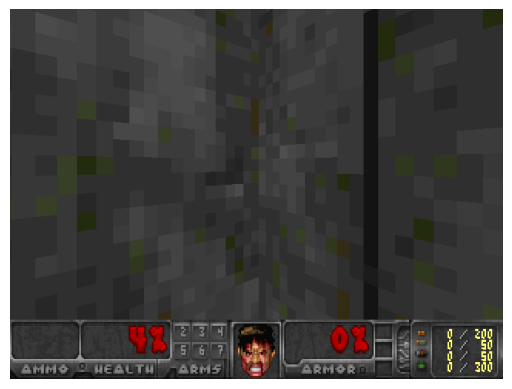

In [21]:
# Testing if the image from the state can be plotted in order to pass it to the NN later
plt.axis('off')
plt.imshow(img)

In [22]:
game.close()

## Deep Q-Learning

In [5]:
# Testing if there is a GUP available

if len(tf.config.experimental.list_physical_devices("GPU")) > 0:
    print("GPU available")
    DEVICE = "/gpu:0"
else:
    print("No GPU available")
    DEVICE = "/cpu:0"

No GPU available


2023-08-08 21:29:58.835176: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-08 21:29:58.837757: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [7]:
# tf.compat.v1.enable_eager_execution()
# tf.executing_eagerly()

In [29]:
# Q-learning settings
learning_rate = 0.00025
discount_factor = 0.99
replay_memory_size = 10000
num_train_epochs = 5 # 
learning_steps_per_epoch = 1000 # Originally 2000
target_net_update_steps = 250 # Originally 1000

In [30]:
# NN learning settings
batch_size = 64

# Training regime
test_episodes_per_epoch = 100 # Originally 100

In [31]:
# Other parameters
frames_per_action = 12
resolution = (120, 156,3) # Added 3 for RBG
episodes_to_watch = 20

In [32]:
save_model = True
load = False
skip_learning = False
watch = True

In [33]:
num_actions = 3 # From 8 to 3

In [11]:
# VizDom is in this path
# /home/ric_ml/miniconda3/envs/tf/lib/python3.11/site-packages/vizdoom

In [12]:
# Configuration file path
# config_file_path = os.path.join("/home/ric_ml/miniconda3/envs/tf/lib/python3.11/site-packages/vizdoom/scenarios", "basic.cfg")
config_file_path = os.path.join("/mnt/c/Users/rzamb/Documents/Desktop/UMD/612_Deep_Learning/doomRL/doomRL/lib/python3.10/site-packages/vizdoom/scenarios", "health_gathering_supreme.cfg")
model_savefolder = "/mnt/c/Users/rzamb/Documents/Desktop/UMD/612_Deep_Learning/doomRL/healthModelv3"

In [13]:
os.getcwd()

'/mnt/c/Users/rzamb/Documents/Desktop/UMD/612_Deep_Learning/doomRL'

In [14]:
config_file_path

'/mnt/c/Users/rzamb/Documents/Desktop/UMD/612_Deep_Learning/doomRL/doomRL/lib/python3.10/site-packages/vizdoom/scenarios/health_gathering_supreme.cfg'

In [15]:
# DQN Code refractored from the following source:
# https://github.com/Farama-Foundation/ViZDoom/blob/master/examples/python/learning_tensorflow.py

In [16]:
def preprocess(img):
    img = skimage.transform.resize(img, resolution)
    img = img.astype(np.float32)
    img = np.expand_dims(img, axis=-1)

    return tf.stack(img)

In [17]:
def initialize_game():
    print("Initializing doom...")
    game = vizdoom.DoomGame()
    game.load_config(config_file_path)
    game.set_window_visible(False)
    game.set_mode(vizdoom.Mode.PLAYER)
    #game.set_screen_format(vizdoom.ScreenFormat.GRAY8)
    game.set_screen_format(vizdoom.ScreenFormat.RGB24)
    game.set_screen_resolution(vizdoom.ScreenResolution.RES_640X480)
    game.init()
    print("Doom initialized.")

    return game

In [18]:
# In cell below num_actions=8 I changed to num_actions (defined
# above as equalto 3), in order to test with the basic setting

In [19]:
class DQNAgent:
    def __init__(
        self, num_actions=num_actions, epsilon=1, epsilon_min=0.1, epsilon_decay=0.9995, load=load
    ):
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.discount_factor = discount_factor
        self.num_actions = num_actions
        #self.optimizer = SGD(learning_rate)
        self.optimizer = keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=1.0)

        if load:
            print("Loading model from: ", model_savefolder)
            self.dqn = tf.keras.models.load_model(model_savefolder)
        else:
            #self.dqn = DQN(self.num_actions)
            #self.target_net = DQN(self.num_actions)
            self.dqn = create_q_model()
            self.target_net = create_q_model()

    def update_target_net(self):
        self.target_net.set_weights(self.dqn.get_weights())

    def choose_action(self, state):
        if self.epsilon < np.random.uniform(0, 1):
            action = int(tf.argmax(self.dqn(tf.reshape(state, (1, 120, 156, 3))), axis=1)) # changed last number 1
        else:
            action = np.random.choice(range(self.num_actions), 1)[0]

        return action

    def train_dqn(self, samples):
        screen_buf, actions, rewards, next_screen_buf, dones = split_tuple(samples)

        row_ids = list(range(screen_buf.shape[0]))

        ids = extractDigits(row_ids, actions)
        done_ids = extractDigits(np.where(dones)[0])

        with tf.GradientTape() as tape:
            tape.watch(self.dqn.trainable_variables)

            
            Q_prev = tf.gather_nd(self.dqn(screen_buf), ids)

            Q_next = self.target_net(next_screen_buf)
            Q_next = tf.gather_nd(
                Q_next,
                extractDigits(row_ids, tf.argmax(agent.dqn(next_screen_buf), axis=1)),
            )

            q_target = rewards + self.discount_factor * Q_next

            if len(done_ids) > 0:
                done_rewards = tf.gather_nd(rewards, done_ids)
                q_target = tf.tensor_scatter_nd_update(
                    tensor=q_target, indices=done_ids, updates=done_rewards
                )

            td_error = tf.keras.losses.MSE(q_target, Q_prev)
            #td_error = tf.keras.losses.Huber(q_target, Q_prev)

        gradients = tape.gradient(td_error, self.dqn.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.dqn.trainable_variables))

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        else:
            self.epsilon = self.epsilon_min

In [20]:
def split_tuple(samples):
    samples = np.array(samples, dtype=object)
    screen_buf = tf.stack(samples[:, 0])
    actions = samples[:, 1]
    rewards = tf.stack(samples[:, 2])
    next_screen_buf = tf.stack(samples[:, 3])
    dones = tf.stack(samples[:, 4])
    return screen_buf, actions, rewards, next_screen_buf, dones


def extractDigits(*argv):
    if len(argv) == 1:
        return list(map(lambda x: [x], argv[0]))

    return list(map(lambda x, y: [x, y], argv[0], argv[1]))


def get_samples(memory):
    if len(memory) < batch_size:
        sample_size = len(memory)
    else:
        sample_size = batch_size

    return sample(memory, sample_size)

In [21]:
def run(agent, game, replay_memory):
    time_start = time()

    for episode in range(num_train_epochs):
        train_scores = []
        print("\nEpoch %d\n-------" % (episode + 1))

        game.new_episode()

        for i in trange(learning_steps_per_epoch, leave=False):
            state = game.get_state()
            screen_buf = preprocess(state.screen_buffer)
            action = agent.choose_action(screen_buf)
            reward = game.make_action(actions[action], frames_per_action)
            done = game.is_episode_finished()

            if not done:
                next_screen_buf = preprocess(game.get_state().screen_buffer)
            else:
                next_screen_buf = tf.zeros(shape=screen_buf.shape)

            if done:
                train_scores.append(game.get_total_reward())

                game.new_episode()

            replay_memory.append((screen_buf, action, reward, next_screen_buf, done))

            if i >= batch_size:
                agent.train_dqn(get_samples(replay_memory))

            if (i % target_net_update_steps) == 0:
                agent.update_target_net()

        train_scores = np.array(train_scores)
        print(
            "Results: mean: {:.1f}±{:.1f},".format(
                train_scores.mean(), train_scores.std()
            ),
            "min: %.1f," % train_scores.min(),
            "max: %.1f," % train_scores.max(),
        )

        test(test_episodes_per_epoch, game, agent)
        print("Total elapsed time: %.2f minutes" % ((time() - time_start) / 60.0))

In [22]:
def test(test_episodes_per_epoch, game, agent):
    test_scores = []

    print("\nTesting...")
    for test_episode in trange(test_episodes_per_epoch, leave=False):
        game.new_episode()
        while not game.is_episode_finished():
            state = preprocess(game.get_state().screen_buffer)
            best_action_index = agent.choose_action(state)
            game.make_action(actions[best_action_index], frames_per_action)

        r = game.get_total_reward()
        test_scores.append(r)

    test_scores = np.array(test_scores)
    print(
        f"Results: mean: {test_scores.mean():.1f}±{test_scores.std():.1f},",
        "min: %.1f" % test_scores.min(),
        "max: %.1f" % test_scores.max(),
    )

In [23]:
conv_base = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_shape=(120, 156, 3,),
)

94668760/94668760 [==============================] - 3s 0us/step


In [24]:
conv_base.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 120, 156, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 126, 162, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 60, 78, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 62, 80, 64)           0         ['conv1_conv[0][0]']          
                                                                                         

In [25]:
def create_q_model():
    # Network defined by the Deepmind paper
    inputs = layers.Input(shape=(120, 156, 3,))

    # Previous Convolutions on the frames on the screen
    #layer1 = layers.Conv2D(8, 6, strides=3, activation="relu")(inputs)
    #layer2 = layers.Conv2D(8, 3, strides=2, activation="relu")(layer1)

    # Convolutions on the frames on the screen with feature extraction from Xception Network
    ResNet_Base = conv_base(inputs)
    
    layer1 = layers.Flatten()(ResNet_Base)

    layer2 = layers.Dense(512, activation="relu")(layer1)
    action = layers.Dense(num_actions, activation="linear")(layer2)

    return keras.Model(inputs=inputs, outputs=action)

In [34]:
#if __name__ == "__main__":
agent = DQNAgent()
game = initialize_game()
replay_memory = deque(maxlen=replay_memory_size)

n = game.get_available_buttons_size()
actions = [list(a) for a in it.product([0, 1], repeat=n)]

with tf.device(DEVICE):

    if not skip_learning:
        print("Starting the training!")

        run(agent, game, replay_memory)

        game.close()
        print("======================================")
        print("Training is finished.")

        if save_model:
            agent.dqn.save(model_savefolder)

    game.close()

    if watch:
        game.set_window_visible(True)
        game.set_mode(vizdoom.Mode.ASYNC_PLAYER)
        game.init()

        for _ in range(episodes_to_watch):
            game.new_episode()
            while not game.is_episode_finished():
                state = preprocess(game.get_state().screen_buffer)
                best_action_index = agent.choose_action(state)

                # Instead of make_action(a, frame_repeat) in order to make the animation smooth
                game.set_action(actions[best_action_index])
                for _ in range(frames_per_action):
                    game.advance_action()

            # Sleep between episodes
            sleep(1.0)
            score = game.get_total_reward()
            print("Total score: ", score)

Initializing doom...
Doom initialized.
Starting the training!

Epoch 1
-------


Results: mean: 327.2±79.6, min: 156.0, max: 572.0,

Testing...


Results: mean: 307.6±74.1, min: 156.0 max: 572.0
Total elapsed time: 57.13 minutes

Epoch 2
-------


Results: mean: 307.9±90.6, min: 156.0, max: 604.0,

Testing...


Results: mean: 325.6±85.6, min: 156.0 max: 604.0
Total elapsed time: 115.64 minutes

Epoch 3
-------


Results: mean: 311.8±95.4, min: 156.0, max: 508.0,

Testing...


Results: mean: 296.9±48.2, min: 156.0 max: 444.0
Total elapsed time: 175.10 minutes

Epoch 4
-------


Results: mean: 316.6±52.4, min: 284.0, max: 508.0,

Testing...


Results: mean: 294.1±48.3, min: 156.0 max: 444.0
Total elapsed time: 235.38 minutes

Epoch 5
-------


Results: mean: 340.9±70.9, min: 284.0, max: 508.0,

Testing...


Results: mean: 290.4±27.9, min: 156.0 max: 444.0
Total elapsed time: 295.77 minutes
Training is finished.


INFO:tensorflow:Assets written to: /mnt/c/Users/rzamb/Documents/Desktop/UMD/612_Deep_Learning/doomRL/healthModelv3/assets


INFO:tensorflow:Assets written to: /mnt/c/Users/rzamb/Documents/Desktop/UMD/612_Deep_Learning/doomRL/healthModelv3/assets


Total score:  197.0
Total score:  204.0
Total score:  198.0
Total score:  208.0
Total score:  213.0
Total score:  264.0
Total score:  201.0
Total score:  204.0
Total score:  211.0
Total score:  201.0
Total score:  200.0
Total score:  200.0
Total score:  201.0
Total score:  201.0
Total score:  210.0
Total score:  201.0
Total score:  209.0
Total score:  88.0
Total score:  214.0
Total score:  208.0


In [35]:
game.close()

In [38]:
imgPros = preprocess(img)

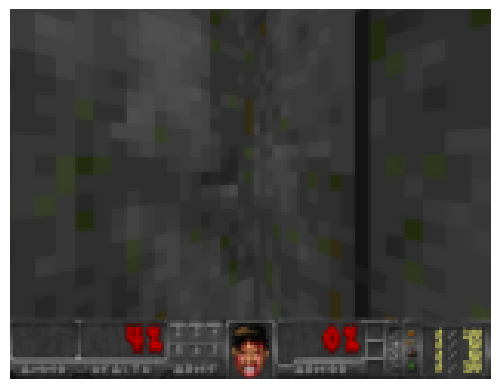

In [39]:
plt.axis('off')
plt.imshow(imgPros[:,:,:,0])

In [40]:
imgPros.shape

TensorShape([120, 156, 3, 1])

To record the apisodes follow the example in VizDoom GitHub: https://github.com/Farama-Foundation/ViZDoom/blob/master/examples/python/record_episodes.py
<br>
Prior to the episode loop add the following line of code:<br>

```python
# Episodes can be recorder in any available mode (PLAYER, ASYNC_PLAYER, SPECTATOR, ASYNC_SPECTATOR)
game.set_mode(vzd.Mode.PLAYER
```

Then, create the new episode with the following arguments <br>
`game.new_episode("episode" + str(i) + "_rec.lmp")`

After the game is closed insert the following lines of code: <br>

```python
# New render settings for replay
game.set_screen_resolution(vzd.ScreenResolution.RES_800X600)
game.set_render_hud(Tru)

# Replay can be played in any mode.
game.set_mode(vzd.Mode.SPECT
```
<br>

Then, to replay the episode we need another for loop to replay each episode:
<br>

```python
    for i in range(episodes):
    
    # Replays episodes stored in given file. Sending game command will interrupt playback    .
    game.replay_episode("episode" + str(i) + "_rec.lmp    "    )

    while not game.is_episode_finishe    d():
        s = game.get_st    a    te()

        # Use advance_action instead of make_    action.
        game.advance_    a    ction()

        r = game.get_las    t_reward()
        # game.get_last_action is not supported and don't work for replay at     t    he moment.

        print("State #" + s    tr(s.number))
        print("Game variables:", s.game    _variables[0])
        prin    t("Reward:", r)
        print("=======    =    =============")

    print("Episode    ", i, "finished.")
    print("total reward:", game
        print("************************")
        *    ************
```

Finally, we can delete the files with the following snippet of code:

```
# Delete recordings (*.lmp files).
for i in range(episodes):
    os.remove("episode" + str(i) + "_rec.lmp")
```*****")

game.close()ATOR))

In [54]:
screen_buf, actions, rewards, next_screen_buf, dones = split_tuple(get_samples(replay_memory))

In [56]:
screen_buf.shape

TensorShape([64, 30, 45, 1])

In [68]:
print(agent.dqn(screen_buf))

None


In [98]:
next_screen_buf.shape

TensorShape([64, 30, 45, 1])

In [100]:
print(agent.target_net(next_screen_buf))

None


In [70]:
#agent
tf.compat.v1.trainable_variables(scope=None)

[]

In [72]:
print(dir(agent))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'choose_action', 'discount_factor', 'dqn', 'epsilon', 'epsilon_decay', 'epsilon_min', 'num_actions', 'optimizer', 'target_net', 'train_dqn', 'update_target_net']


In [74]:
print(dir(agent.dqn))

['_SCALAR_UPRANKING_ON', '_TF_MODULE_IGNORED_PROPERTIES', '__annotations__', '__call__', '__class__', '__copy__', '__deepcopy__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_activity_regularizer', '_add_trackable', '_add_trackable_child', '_add_variable_with_custom_getter', '_aggregate_exact_metrics', '_assert_compile_was_called', '_assert_weights_created', '_auto_config', '_auto_get_config', '_auto_track_sub_layers', '_autocast', '_autographed_call', '_base_model_initialized', '_build_input_shape', '_call_spec', '_callable_losses', '_captured_weight_regularizer', '_cast_single_input', '_check_call_args', '_check_sample_weight_warning', '_checkpoint', '_checkpoint_depend

In [97]:
print(agent.dqn.inputs)

None


In [58]:
row_ids = list(range(screen_buf.shape[0]))

In [61]:
actions

array([2, 2, 1, 0, 2, 2, 1, 1, 1, 2, 0, 0, 1, 1, 0, 2, 0, 0, 1, 0, 2, 0,
       0, 2, 2, 1, 0, 2, 1, 1, 0, 0, 1, 0, 0, 1, 1, 2, 2, 1, 1, 0, 1, 2,
       1, 0, 1, 1, 2, 2, 2, 1, 1, 0, 0, 0, 1, 2, 1, 2, 2, 1, 0, 1],
      dtype=object)

In [65]:
ids = extractDigits(row_ids, actions)
done_ids = extractDigits(np.where(dones)[0])
done_ids

[[2], [28], [29]]

In [66]:
dones

<tf.Tensor: shape=(64,), dtype=bool, numpy=
array([False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])>

In [ ]:
class DQN(Model):
    def __init__(self, num_actions):
        super().__init__()
        self.conv1 = Sequential(
            [
                Conv2D(8, kernel_size=6, strides=3, input_shape=(30, 45, 1)),
                BatchNormalization(),
                ReLU(),
            ]
        )

        self.conv2 = Sequential(
            [
                Conv2D(8, kernel_size=3, strides=2, input_shape=(9, 14, 8)),
                BatchNormalization(),
                ReLU(),
            ]
        )

        self.flatten = Flatten()

        self.state_value = Dense(1)
        self.advantage = Dense(num_actions)

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.flatten(x)
        x1 = x[:, :96]
        x2 = x[:, 96:]
        x1 = self.state_value(x1)
        x2 = self.advantage(x2)

        x = x1 + (x2 - tf.reshape(tf.math.reduce_mean(x2, axis=1), shape=(-1, 1)))

In [84]:
# # Variables from random actions. For reference:
# wadFilePath = os.path.join("~/miniconda3/envs/tf/lib/python3.11/site-packages/vizdoom/scenarios", "basic.wad")
# game.set_doom_scenario_path(wadFilePath)
# game.set_doom_map("map01")

# # Rendering Options
# game.set_screen_resolution(ScreenResolution.RES_640X480)
# game.set_screen_format(ScreenFormat.RGB24)
# game.set_render_hud(False) # If true it shows you the game dock with: ammo, health, arms, face, armor
# game.set_render_crosshair(False) # If true it shows the cross indicating where the weapon is aiming
# game.set_render_weapon(True)
# game.set_render_decals(False) # No visible changes noted when set to true 
# game.set_render_particles(False) # No visible changes noted when set to true 

# # Setting buttins that can be used by the agent
# game.add_available_button(Button.MOVE_LEFT)
# game.add_available_button(Button.MOVE_RIGHT)
# game.add_available_button(Button.ATTACK)

# # Determine which game variables (health, ammo, weapon availability etc.) will be included in the state we get in each timestep
# game.add_available_game_variable(GameVariable.AMMO2)

# # Other settings such as the visibility of the window, the episode timeout (in tics/frames), or start time
# game.set_episode_timeout(200)
# game.set_episode_start_time(10)
# game.set_window_visible(True)

# game.set_living_reward(-1)

# shoot = [0, 0, 1]
# left = [1, 0, 0]
# right = [0, 1, 0]
# actions = [shoot, left, right]